# 1. Import modules and load dataset

In [1]:
import datetime, os, random, sys, torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
import tqdm

import ci_ivae_main as CI_iVAE
import ci_ivae_src.util as UTIL

# seed number for reproducibility
seed = 0

# make result folder
now = datetime.datetime.now()
result_path = './results/ci_ivae-time=%d-%d-%d-%d-%d' % (now.month, now.day, now.hour, now.minute, now.second)
os.makedirs(result_path, exist_ok=True)
print('result_path: ', result_path)

# load and pre-process the FashionMNIST dataset
onehot_enc = OneHotEncoder(handle_unknown='ignore')
transform = Compose([ToTensor(),
                     Lambda(lambda x: x.view(1, 28, 28)),
                     Lambda(lambda x: x.transpose(1, 2))])

fashionmnist_train = torchvision.datasets.FashionMNIST(root='./FashionMNIST',
                                                       train=True,
                                                       download=True,
                                                       transform=transform)
fashionmnist_test = torchvision.datasets.FashionMNIST(root='./FashionMNIST',
                                                      train=False,
                                                      download=True,
                                                      transform=transform)

x_train, u_train = fashionmnist_train.data, fashionmnist_train.targets
x_test, u_test = fashionmnist_test.data, fashionmnist_test.targets

x_train = np.reshape(x_train, (-1, 28*28))/255.0
x_test = np.reshape(x_test, (-1, 28*28))/255.0
u_train = onehot_enc.fit_transform(u_train.reshape(-1, 1)).toarray()
u_test = onehot_enc.fit_transform(u_test.reshape(-1, 1)).toarray()

x_train, x_val, u_train, u_val = train_test_split(x_train, u_train,
                                                  test_size=(1/6),
                                                  random_state=seed)

result_path:  ./results/ci_ivae-time=2-13-18-56-39


# 2. Build and train CI-iVAE

/home/kimyoun/Downloads/CI-iVAE_recent-main/ci_ivae_main.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=dtype)
/home/kimyoun/Downloads/CI-iVAE_recent-main/ci_ivae_main.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(x_val, dtype=dtype)
[Epoch 29/100] Computing loss terms on train: 100%|██████████| 195/195 [00:16<00:00, 11.98it/s]


[Epoch 60/100] Computing loss terms on train: 100%|██████████| 195/195 [00:06<00:00, 29.31it/s]


[Epoch 91/100] Computing loss terms on train: 100%|██████████| 195/195 [00:06<00:00, 27.95it/s]


[Epoch 100/100] Computing loss terms on val: 100%|██████████| 39/39 [00:02<00:00, 14.97it/s]


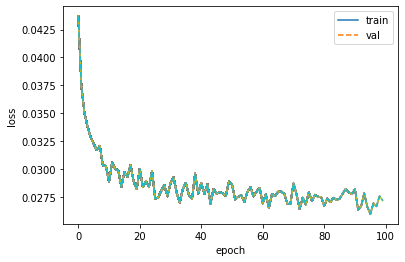

In [2]:
# build CI-iVAE networks
dim_x, dim_u = np.shape(x_train)[1], np.shape(u_train)[1]
ci_ivae = CI_iVAE.model(dim_x=dim_x, dim_u=dim_u)

# train CI-iVAE networks. Results will be saved at the result_path
CI_iVAE.fit(model=ci_ivae, x_train=x_train, u_train=u_train,
            x_val=x_val, u_val=u_val, seed=seed, 
            result_path=result_path)

# 3. Extract features and evaluate representations with t-SNE, SSW/SST, and K-NN classifier performance

In [3]:
# extract features with trained CI-iVAE networks
z_train = CI_iVAE.extract_feature(result_path=result_path, x=x_train)
z_test = CI_iVAE.extract_feature(result_path=result_path, x=x_test)
z_train = z_train.detach().cpu().numpy()
z_test = z_test.detach().cpu().numpy()

[Text(0.5, 1.0, 'T-SNE projection')]

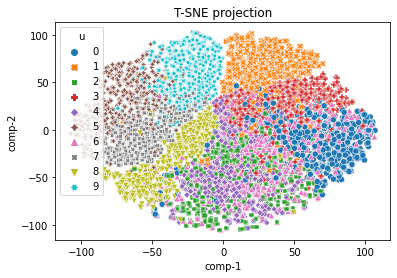

In [4]:
tsne_test = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=3).fit_transform(z_test)

df = pd.DataFrame()
df["u"] = np.argmax(u_test, axis=1)
df["comp-1"], df["comp-2"] = tsne_test[:,0], tsne_test[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue="u", style="u",
                palette=sns.color_palette(),
                data=df).set(title="T-SNE projection")

In [5]:
# compute SSW/SST
sst = np.sum((z_test - np.mean(z_test, axis=0))**2)
ssw = np.sum([np.sum((z_test[np.argmax(u_test, axis=1)==i]
                      -np.mean(z_test[np.argmax(u_test, axis=1)==i],
                               axis=0))**2)
              for i in range(len(np.unique(np.argmax(u_test, axis=1))))])
print('ssw/sst: %.3f' % (ssw/sst))

ssw/sst: 0.519


In [6]:
# compute knn classifier accuracy
from sklearn.neighbors import KNeighborsClassifier

def calculate_knn_accuracy(z_train, u_train,
                           z_test, u_test, k=5):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(z_train, u_train)

    u_pred = np.array(np.argmax(neigh.predict(z_test), axis=1))
    u_test = np.array(np.argmax(u_test, axis=1))
    accuracy = np.mean(np.equal(u_pred, u_test))
    return accuracy

knn_accuracy = calculate_knn_accuracy(z_train, u_train, z_test, u_test)
print('KNN accuracy: ', knn_accuracy)

/home/kimyoun/.local/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN accuracy:  0.7908


# 4. Explanation with LIME

In [7]:
# rank latent factors based on the amount of information about covariates
clf = LogisticRegression(random_state=seed)
selector = RFE(clf, n_features_to_select=1, step=1)
selector = selector.fit(z_train, np.argmax(u_train, axis=1))

/home/kimyoun/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kimyoun/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

In [8]:
# build LIME pipeline
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(training_data=x_train,
                                                   mode='regression',
                                                   training_labels=z_train,
                                                   discretize_continuous=False,
                                                   verbose=False,
                                                   random_state=seed
                                                   )
saved_model = torch.load(result_path+'/model.pth')
prior, encoder, decoder = saved_model['prior'], saved_model['encoder'], saved_model['decoder']
latent_dim = np.where(selector.ranking_==1)[0][0]

def LIME_feature_extraction(data):
    dtype = saved_model['dtype']
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    data = torch.tensor(data, dtype=dtype)
    if device == 'cuda':
        data = data.cuda() 
    encoder.eval()
    encoder.to(device)
    
    z_mean, z_log_var = encoder(data)
    z_sample = UTIL.sampling(z_mean, z_log_var)
    
    return z_sample.detach().cpu().numpy()[:, latent_dim]

[Test sample]


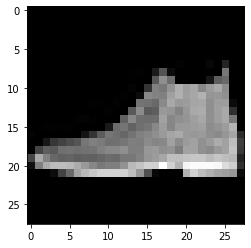

In [9]:
print('[Test sample]')
img = x_test[0]
plt.imshow(np.reshape(img.detach().numpy(), (28, 28)), cmap='gray')
plt.show()

In [10]:
print('[LIME results] Feature names indicate pixel indexes and LIME scores show how pixel values affect on the latent factor having the largest information about covariates')
exp = explainer.explain_instance(img.detach().numpy(), LIME_feature_extraction)
exp.show_in_notebook(show_table=True, show_all=False)

[LIME results] Feature names indicate pixel indexes and LIME scores show how pixel values affect on the latent factor having the largest information about covariates


# 5. Advanced analysis for image data

1st row: test samples, 2nd row: positively related pixels, 3rd row: negatively related pixels


<ipython-input-11-152c6e28e59a>:32: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0, hspace=0)


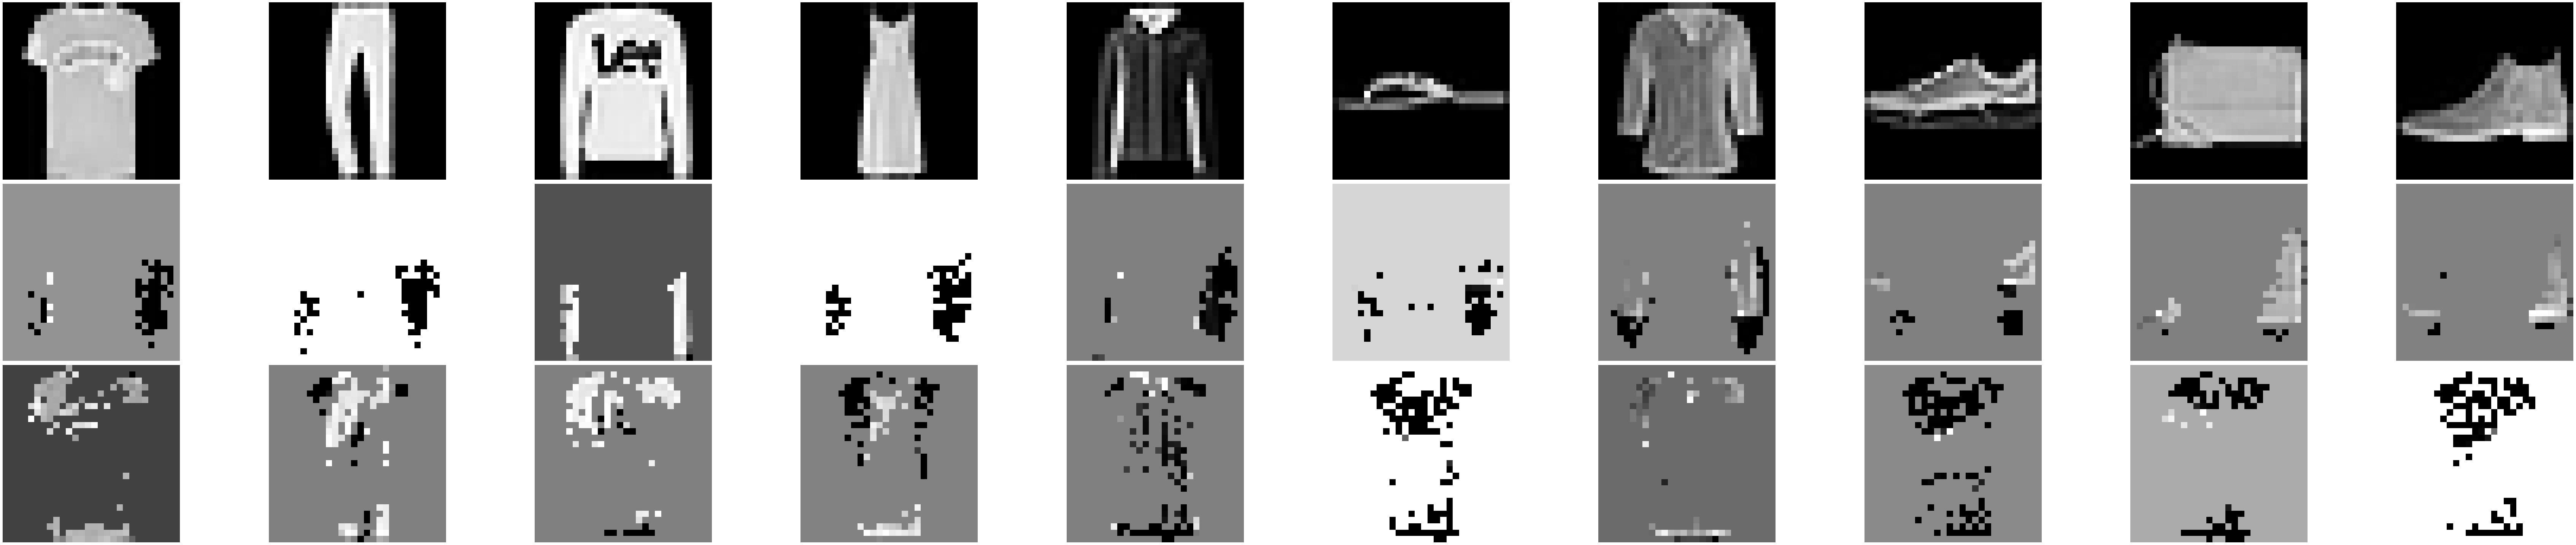

In [11]:
# visualize regions positively and negatively affect on the top 1 latent factor
print('1st row: test samples, 2nd row: positively related pixels, 3rd row: negatively related pixels')

fig, axes = plt.subplots(3, 10, figsize=(100, 20), constrained_layout=True)
for i in range(10):
    img = x_test[np.where(np.argmax(u_test, axis=1)==i)[0][0]]
    fashionmnist_explainer = explainer.explain_instance(img.detach().numpy(),
                                                        LIME_feature_extraction,
                                                        num_features=int(28*28/5),
                                                        num_samples=10000)

    pos_mask, neg_mask = np.zeros(28*28), np.zeros(28*28)
    for feature, score in fashionmnist_explainer.as_list():
        if score > 0:
            pos_mask[int(feature)] = 1
        elif score < 0:
            neg_mask[int(feature)] = 1
    pos_mask, neg_mask = np.reshape(pos_mask, (28, 28)), np.reshape(neg_mask, (28, 28))
    
    axes[0, i].imshow(np.reshape(img, (28, 28, 1)), cmap='gray')  
    axes[1, i].imshow(0.5*np.ones((28, 28))*(1.0-pos_mask)
                      +np.reshape(img, (28, 28)).detach().numpy()*pos_mask,
                      cmap='gray')
    axes[2, i].imshow(0.5*np.ones((28, 28))*(1.0-neg_mask)
                      +np.reshape(img, (28, 28)).detach().numpy()*neg_mask,
                      cmap='gray')
    
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')
    del(i)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

<ipython-input-12-9c5cf1d43636>:19: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0, hspace=0)


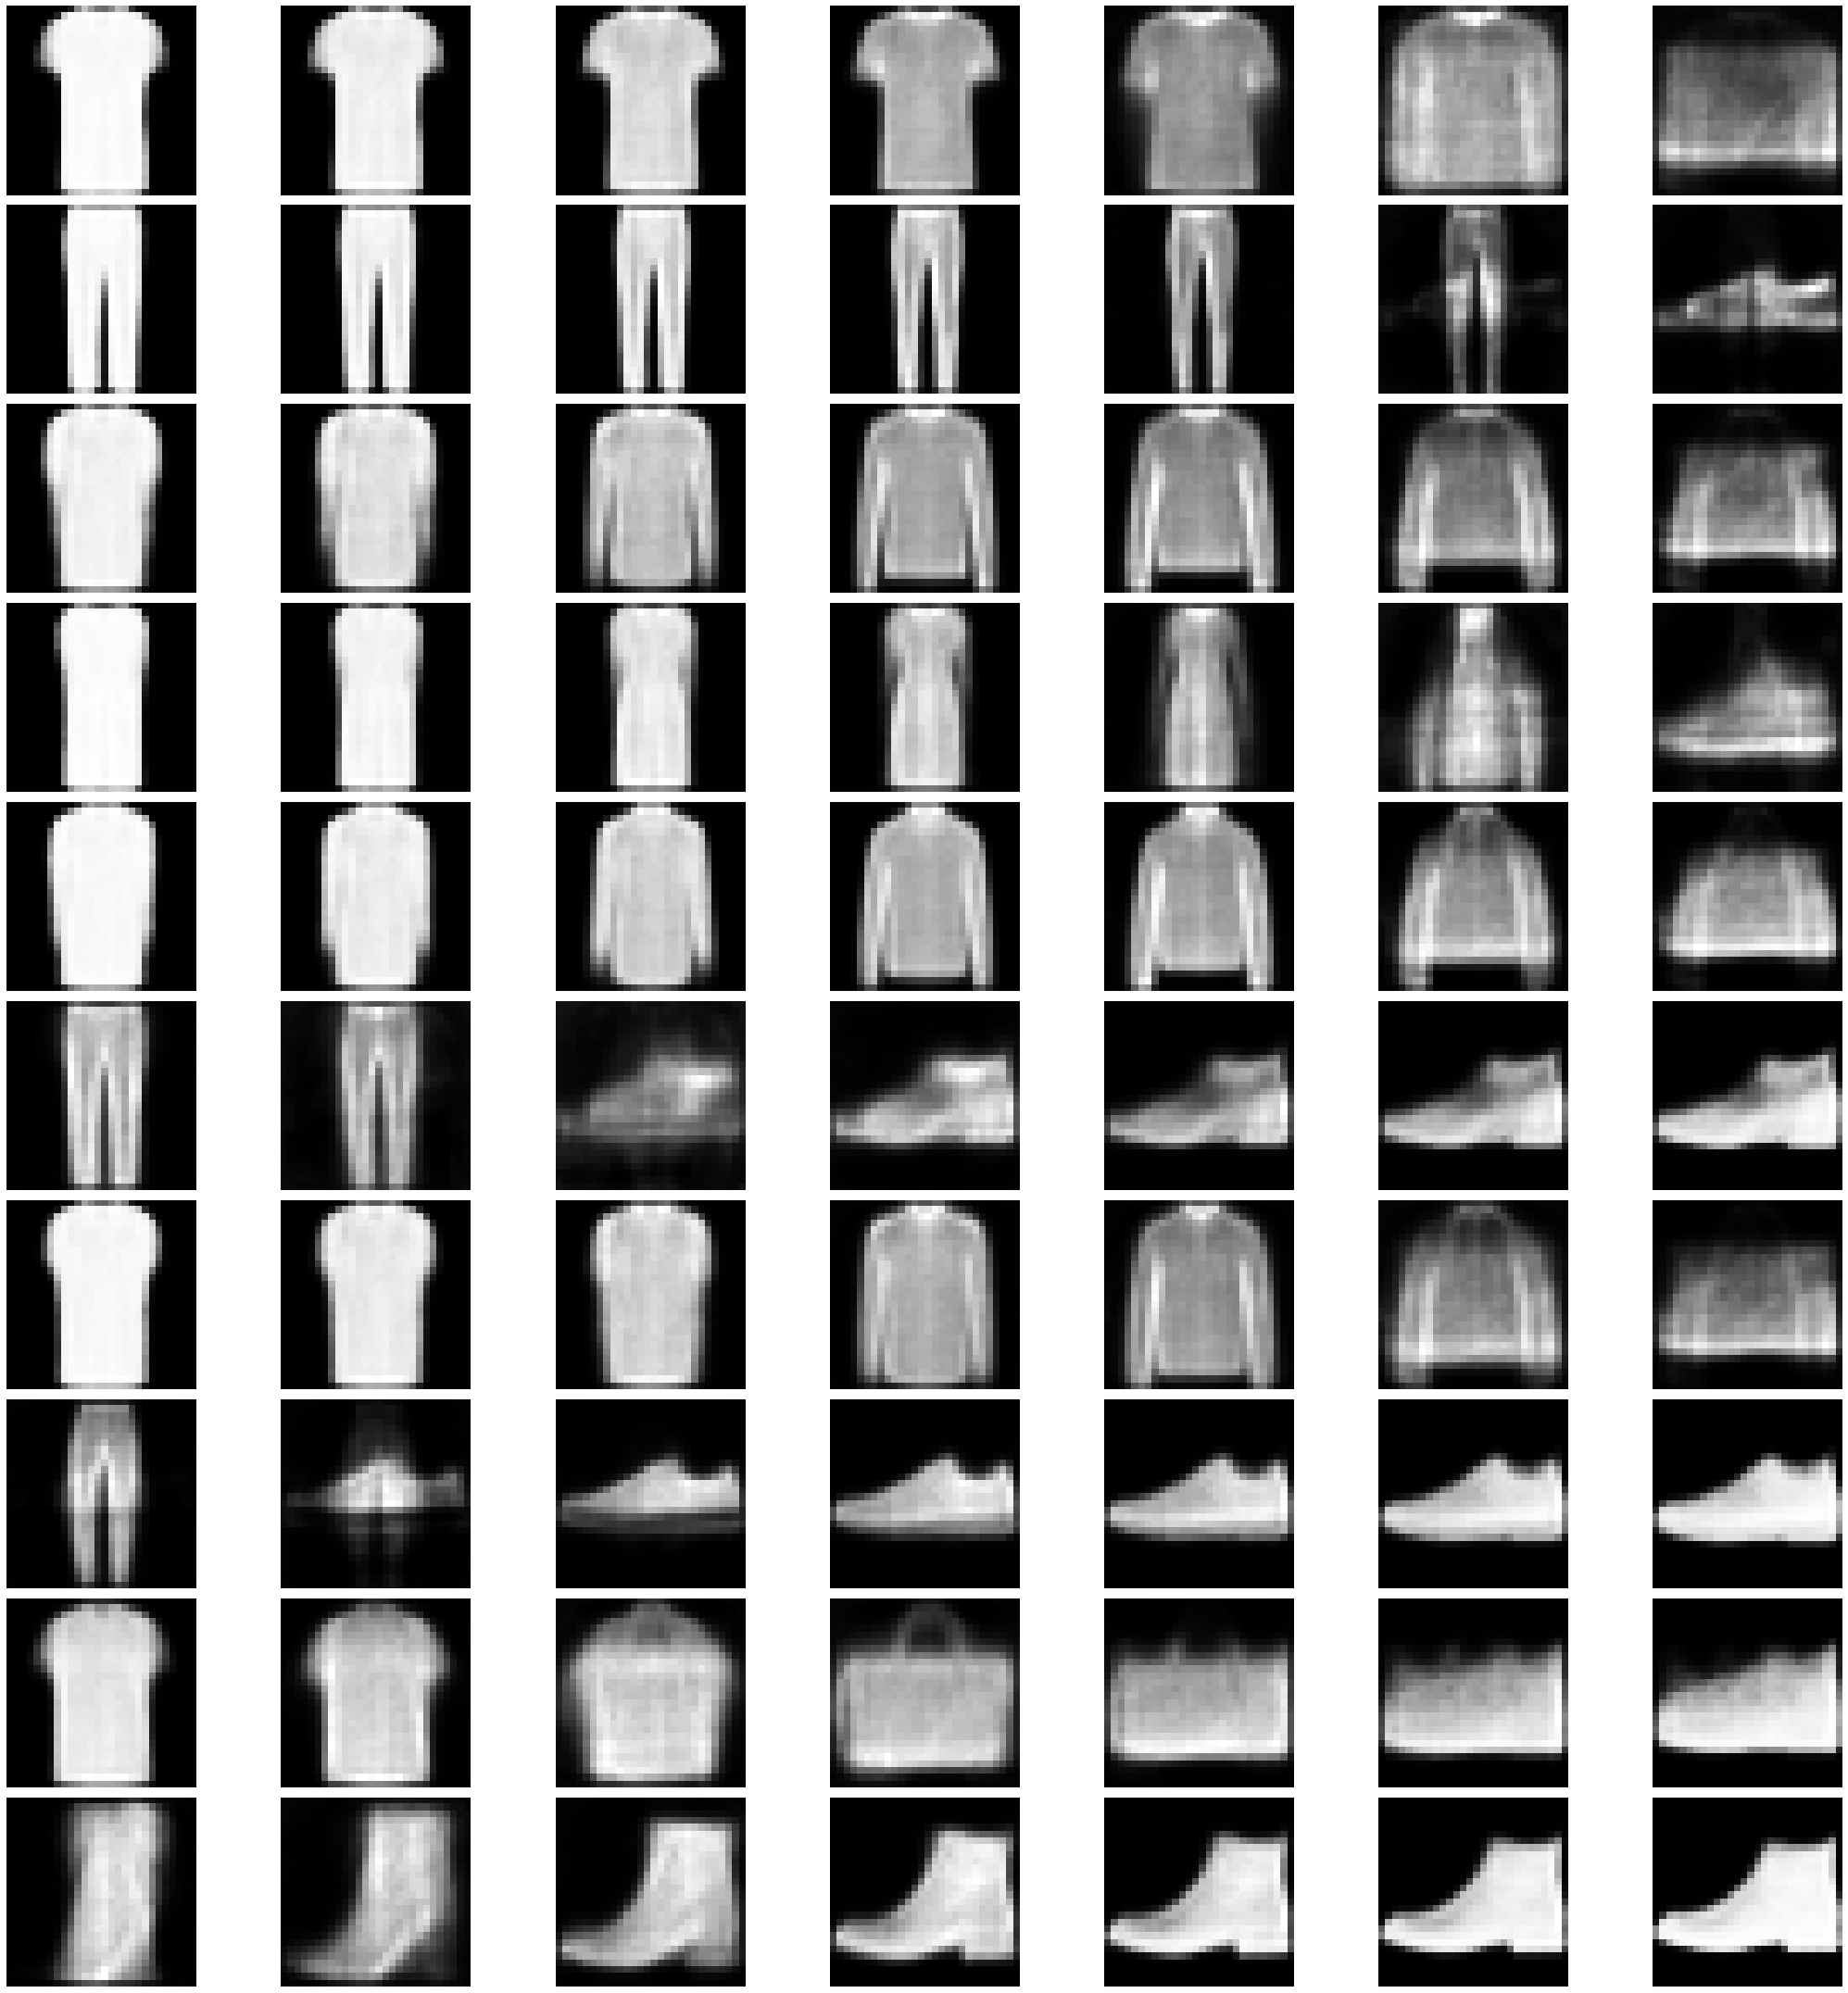

In [12]:
# Generation results
z_mean, z_log_var = CI_iVAE.generate_z(result_path, torch.tensor(np.eye(10), dtype=torch.float32))

latent_dim = np.where(selector.ranking_==1)[0][0]

fig, axes = plt.subplots(10, 7, figsize=(30, 30), constrained_layout=True)
for j in range(7):
    noise = torch.zeros_like(z_log_var)
    noise[:, latent_dim] = torch.exp(0.5*z_log_var.cuda())[:, latent_dim]
    x_generated, _ = decoder(z_mean + (j-3)*noise)
    for i in range(10):
        img = x_generated[i]
        
        axes[i, j].imshow(np.reshape(img.cpu().detach().numpy(), (28, 28, 1)), cmap='gray')
        axes[i, j].axis('off')
        del(i)
    del(j)

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()